# **Land-Use and Land-Cover(LULC) Classification with spectral Indices (Lahore, Pakistan)**

1. Install and Import dependencies

In [10]:
!pip install earthengine-api geemap geopandas pandas matplotlib

In [11]:
import ee, geemap, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt

2. Authenticate and Intialize Earth Engine

In [13]:
ee.Authenticate()
ee.Initialize(project='gee-lahore-lulc')

3. Define Region of Interest

In [14]:
roi = ee.Geometry.Polygon([
    [[74.25, 31.70],
    [74.25, 31.35],
    [74.60, 31.35],
    [74.60, 31.70],
    [74.25, 31.70]]
    ])

4. Load Sentinel-2 Surface Reflectance Data

In [30]:
sentinel= (
    ee.ImageCollection('COPERNICUS/S2_SR')
    .filterBounds(roi)
    .filterDate('2020-01-01', '2024-12-31')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    .select(['B2','B3','B4','B8','B11']) # Select relevant bands before reduction
    .median()
    .clip(roi)
)

5. Compute Spectral Indices

In [31]:
def add_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
    return image.addBands(ndvi).addBands(ndwi).addBands(ndbi)

image = add_indices(sentinel)

6. Initialize Interactive map

In [32]:
Map = geemap.Map(center=[31.52, 74.36], zoom=11)
Map.addLayer(image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel RGB')
Map


Map(center=[31.52, 74.36], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

7. Visualize spectral Indices

In [33]:
Map.addLayer(image.select('NDVI'), {'min': -1, 'max': 1, 'palette': ['brown', 'yellow', 'green']}, 'NDVI')
Map.addLayer(image.select('NDWI'), {'min': -1, 'max': 1, 'palette': ['purple', 'blue']}, 'NDWI')
Map.addLayer(image.select('NDBI'), {'min': -1, 'max': 1, 'palette': ['gray', 'white', 'red']}, 'NDBI')


8. Training Data Definition (Water, Vegetation, Built Up)

Each feature has a landcover label: 0=water, 1=Vegetation, 2= Built-up

In [34]:
water = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([74.35, 31.57]), {'landcover': 0}),
    ee.Feature(ee.Geometry.Point([74.37, 31.59]), {'landcover': 0}),
    ee.Feature(ee.Geometry.Point([74.33, 31.55]), {'landcover': 0}),
                              ])

vegetation = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([74.41, 31.52]), {'landcover': 1}),
    ee.Feature(ee.Geometry.Point([74.43, 31.54]), {'landcover': 1}),
    ee.Feature(ee.Geometry.Point([74.39, 31.50]), {'landcover': 1}),
])

builtup = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([74.36, 31.48]), {'landcover': 2}),
    ee.Feature(ee.Geometry.Point([74.38, 31.47]), {'landcover': 2}),
    ee.Feature(ee.Geometry.Point([74.34, 31.49]), {'landcover': 2}),
                                ])

training_points = water.merge(vegetation).merge(builtup)


9. Sample training Data

In [35]:
bands=['B2','B3','B4','B8','B11','NDVI','NDWI','NDBI']

training=image.select(bands).sampleRegions(
    collection=training_points,
    properties=['landcover'],
    scale=10
)

10. Train Random Forest Classifier

In [36]:
classifier=ee.Classifier.smileRandomForest(100).train(training, 'landcover', bands)

11. Classify the image

In [37]:
classified=image.select(bands).classify(classifier)

12. Visualize Classification

In [42]:
landcover_palette_vis = ['#0000FF', '#008000', '#808080'] # Hexadecimal color strings for blue, green, gray for visualization
landcover_palette_legend = [(0, 0, 255), (0, 128, 0), (128, 128, 128)] # RGB tuples for blue, green, gray for legend

Map.addLayer(classified.select('classification'), {'min': 0, 'max': 2, 'palette': landcover_palette_vis}, 'Landcover Classification')
Map.add_legend(title='Landcover Classification', labels=['Water', 'Vegetation', 'Built-up'], colors=landcover_palette_legend)
Map.add_layer_control()
Map

Map(bottom=214032.0, center=[31.52, 74.36], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

13. Accuracy Assesment

In [46]:
withRandom= training.randomColumn()
split = 0.7
trainSet = withRandom.filter(ee.Filter.lt('random', split))
testSet = withRandom.filter(ee.Filter.gte('random', split))

trainedClassifier = ee.Classifier.smileRandomForest(100).train(trainSet, 'landcover', bands)
validated = testSet.classify(trainedClassifier)

confusion_matrix = validated.errorMatrix('landcover', 'classification')
print('Confusion Matrix:', confusion_matrix.getInfo())

Confusion Matrix: [[1, 0, 0], [0, 0, 1], [0, 0, 1]]


14. NDVI Histogram

Text(0.5, 1.0, 'NDVI Distribution Lahore')

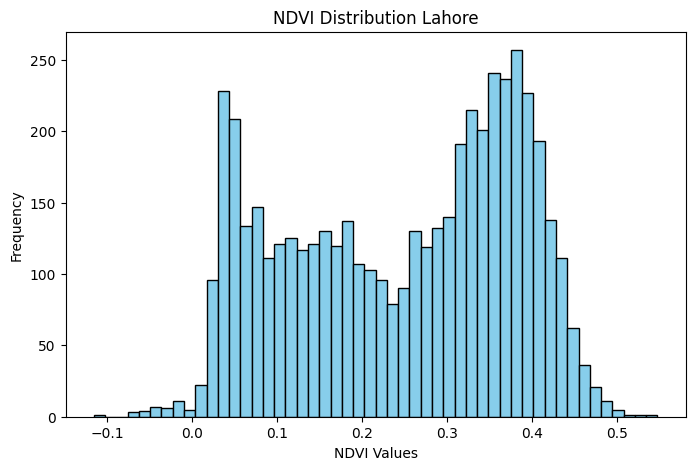

In [47]:
from ast import Num
ndvi_data=image.select('NDVI').sample(region=roi, scale=30, numPixels=5000).aggregate_array('NDVI').getInfo()
plt.figure(figsize=(8, 5))
plt.hist(ndvi_data, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('NDVI Values')
plt.ylabel('Frequency')
plt.title('NDVI Distribution Lahore')